# DS_7331 Machine Learning - Lab 1 - Group 4

### Paticia Attah
### Linda Eliasen
### Senthil Kumar

### BUSINESS UNDERSTANDING

Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). Describe how you would define and measure the outcomes from the dataset. That is, why is this data important and how do you know if you have mined useful knowledge from the dataset? How would you measure the effectiveness of a good prediction algorithm? Be specific.







The H-1B Dataset selected for this project contains data from employers Labor Condition Applications and the case certification determinations processed by the Office of Foreign Labor Certification (OFLC) where the date of the determination was issued on or after October 1, 2016 and on or before June 30, 2017.

The Labor Condition Application (LCA) is a document that a prospective H-1B employer files with the U.S. Department of Labor Employment and Training Administration (DOLETA) when it seeks to employ non-immigrant workers at a specific job occupation in an area of intended employment for no more than three years for the intital approval. Total stay is limited to 6 years. 

An H-1B visa is issued for a specialty occupation, requiring theoretical and practical application of a body of specialized knowledge along with a bachelors degree or its equivalent.  The prospective H-1B employee must also hold a U.S. bachelor's or higher degree, or the equivalent.

US employers must be able to justify the exclusive need for this foreign worker/visa holder and prove that the task cannot be accomplished by a local citizen who may either be unavailable or not qualified, either academically or professionally.

Our goal for this project is to predict the case status of an application submitted by the employer to hire non-immigrant workers under the H-1B visa program. Employers can hire non-immigrant workers only after their LCA petition is certified. The certified LCA petition is then submitted as part of the Petition for a Non-immigrant Worker application for work authorizations for H-1B visa status.

We want to uncover insights that can help employers understand the process of getting their LCA approved. We will investigate WEKA and other software to run data mining algorithms to understand the relationship between attributes and the target variable.  The results will help employers understand which applications that they may consider submitting will be certified.  This information is important to an employer's buisness operations.  It can pinpoint errors or informtion on the appication that may need adjusting to avoid processing delays and also drive the recruiting strategy in denial situations.  
This requires a classification model. Measures of success include accuracy, precision, recall and utltimatley the F Score.

- Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations.

- Precision and recall are two numbers which together are used to evaluate the performance of classification or information retrieval systems. Precision is defined as the fraction of relevant instances among all retrieved instances. Recall, sometimes referred to as ‘sensitivity, is the fraction of retrieved instances among all relevant instances. A perfect classifier has precision and recall both equal to 1.

- Precision and recall are combined together into the F-score, if a single numerical measurement of a system's performance is required.

https://deepai.org/machine-learning-glossary-and-terms/precision-and-recall

### DATA MEANING  & TYPE

The original dataset is the case disclosure file for the 2017 LCA Programs (H-1B, H-1B1, E-3) released by the Department of Labor.  It contained 624,650 observations and 52 informational variables.  

The dataset was trimmed to not only reduce the size but also to remove variables that did not pertain to the analysis (such as address details beyond city and state, phone numbers, salary survey source data).

The final subset of the data includes:
-  H-1B Petitions
-  FT Positions
-  Case Status of Certified, Certified-Withdrawn and Denied
-  Work States in the Contiguous US, including Alaska

The final dataset for use in the analysis contains 575,591 observations and 29 feature variables (including three engineered features as indicated in the table below).  

Original 2017 Data File:  https://www.dol.gov/agencies/eta/foreign-labor/performance


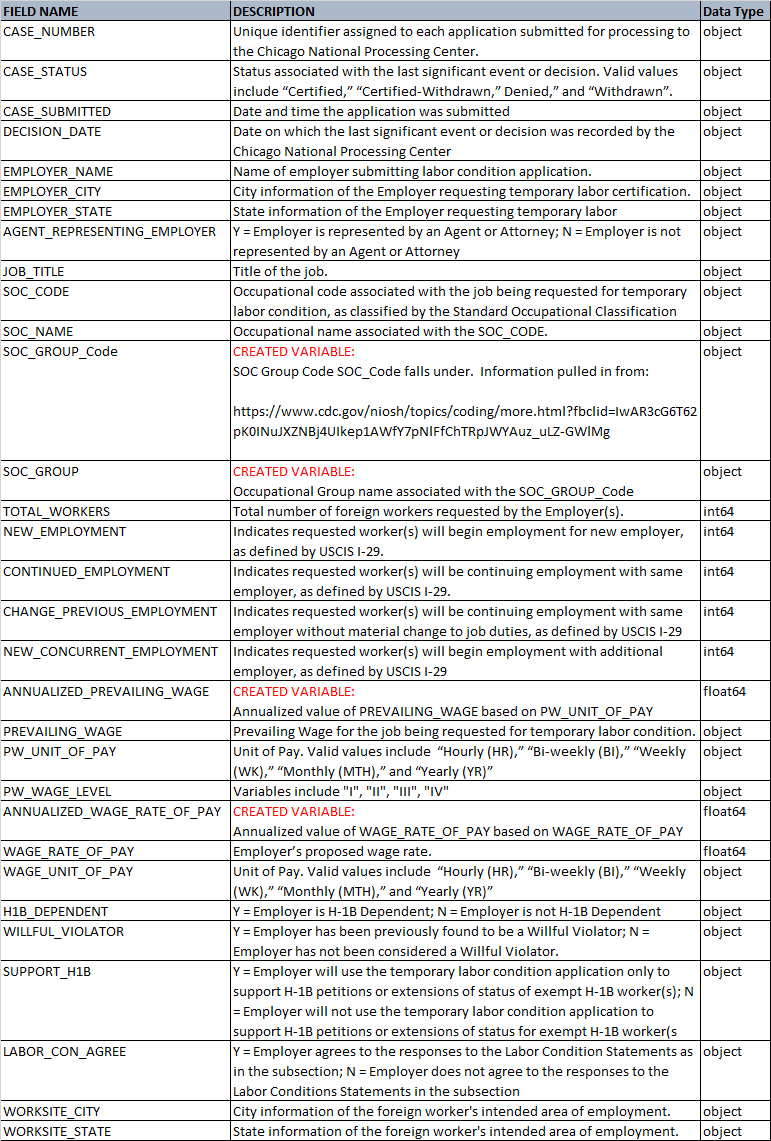

Bringing in the data

In [58]:
import pandas as pd 
import numpy as np
import plotly as py
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore')

#import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools

import plotly.io as pio
pio.renderers.default='notebook'

import imblearn
from imblearn.over_sampling import SMOTE

import sklearn
import squarify

In [59]:
df1 = pd.read_csv('H-1B__Data_FY17.csv')

df1.head(3)


FileNotFoundError: [Errno 2] No such file or directory: 'H-1B__Data_FY17.csv'

In [34]:
df1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575591 entries, 0 to 575590
Data columns (total 31 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   CASE_NUMBER                  575591 non-null  object 
 1   CASE_STATUS                  575591 non-null  object 
 2   CASE_SUBMITTED               575591 non-null  object 
 3   DECISION_DATE                575591 non-null  object 
 4   EMPLOYER_NAME                575552 non-null  object 
 5   EMPLOYER_CITY                575591 non-null  object 
 6   EMPLOYER_STATE               575577 non-null  object 
 7   AGENT_REPRESENTING_EMPLOYER  488476 non-null  object 
 8   JOB_TITLE                    575589 non-null  object 
 9   SOC_CODE                     575591 non-null  object 
 10  SOC_NAME                     575590 non-null  object 
 11  SOC_GROUP_Code               575591 non-null  object 
 12  SOC_GROUP                    575585 non-null  object 
 13 

### Data Manipulation

In [60]:
# NEW COLUMN "CERTIFIED" combines certified & certified-withdrawn. 
# Both indicate the LCA Petition was approved.  Employer withdrew petition after certification.

df1['CERTIFIED'] = np.where(df1['CASE_STATUS']!='DENIED', 'Y','N')

In [61]:
# NEW COLUMN "PAY_ABOVE_PREV_WAGE" 
# Calculates if wage rate is greater than or equal to prevailing wage, classifies as 1/0

df1['PAY_ABOVE_PREV_WAGE'] = np.where(df1['ANNUALIZED_WAGE_RATE_OF_PAY']>=df1['ANNUALIZED_PREVAILING_WAGE'], '1', '0')

pay_compare = df1.get(['ANNUALIZED_WAGE_RATE_OF_PAY', 'ANNUALIZED_PREVAILING_WAGE', 'PAY_ABOVE_PREV_WAGE'])
pay_compare.head(5)

pay_compare_totals_df1 = df1.groupby(['PW_WAGE_LEVEL', 'PAY_ABOVE_PREV_WAGE']).size().reset_index(name='counts')

print(pay_compare_totals_df1)

  PW_WAGE_LEVEL PAY_ABOVE_PREV_WAGE  counts
0       Level I                   0     641
1       Level I                   1  479510
2      Level II                   0      25
3      Level II                   1    8019
4     Level III                   1     213
5      Level IV                   1       9


In [62]:
# NEW COLUMN "DAYS_PROCESS"
#Time span between CASE_SUBMITTED date and DECISION_DATE. 

df1['CASE_SUBMITTED'] = pd.to_datetime(df1['CASE_SUBMITTED'])
df1['DECISION_DATE'] = pd.to_datetime(df1['DECISION_DATE'])

df1['DAYS_PROCESS'] = ((df1['DECISION_DATE'] - df1['CASE_SUBMITTED']).dt.days)

In [38]:
df1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575591 entries, 0 to 575590
Data columns (total 34 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   CASE_NUMBER                  575591 non-null  object        
 1   CASE_STATUS                  575591 non-null  object        
 2   CASE_SUBMITTED               575591 non-null  datetime64[ns]
 3   DECISION_DATE                575591 non-null  datetime64[ns]
 4   EMPLOYER_NAME                575552 non-null  object        
 5   EMPLOYER_CITY                575591 non-null  object        
 6   EMPLOYER_STATE               575577 non-null  object        
 7   AGENT_REPRESENTING_EMPLOYER  488476 non-null  object        
 8   JOB_TITLE                    575589 non-null  object        
 9   SOC_CODE                     575591 non-null  object        
 10  SOC_NAME                     575590 non-null  object        
 11  SOC_GROUP_Code            

### DATA QUALITY

Verify data quality: Explain any missing values, duplicate data, and outliers. Are those mistakes? How do you deal with these problems? Give justifications for your methods.

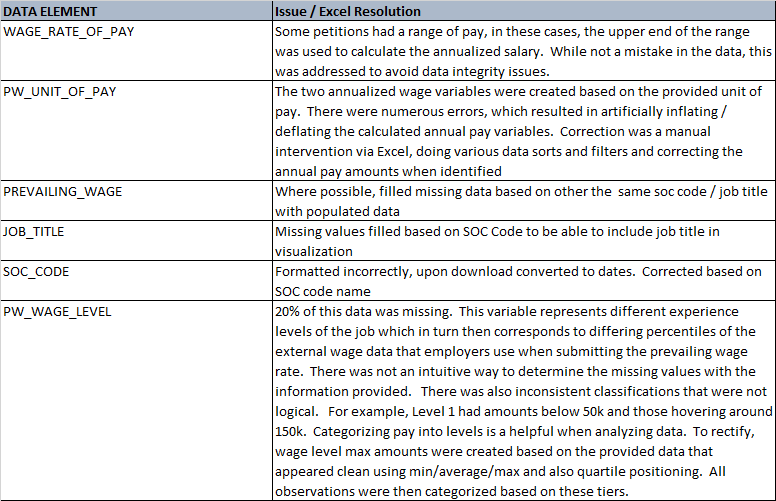

### SIMPLE STATISTICS

In [39]:
#Subset of count variables for summary statistics chart  ERROR UNTIL DAYS_PROCESS IS ADDED ABOVE

dfssc = pd.DataFrame([df1.TOTAL_WORKERS, df1.NEW_EMPLOYMENT, df1.CONTINUED_EMPLOYMENT, df1.DAYS_PROCESS]).transpose()
dfssc.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

TOTAL_WORKERS NEW_EMPLOYMENT CONTINUED_EMPLOYMENT DAYS_PROCESS
count        575591         575591               575591       575591
mean        1.94802       0.848464             0.333414      33.4528
std         4.97541        3.66606              1.27665      129.562
min               1              0                    0            0
25%               1              0                    0            6
50%               1              0                    0            6
75%               1              1                    0            6
max             155            150                   55         2214

Average TOTAL_WORKERS per submission is 1.9, ranging from 1 - 155, with more applications for new employment vs. continued employment. Important to note, only 0.2% of submissions have total workers greater than or equal to 50.  The petition for 155 workers did not supply additional information as to the breakdown between new and continued employment. 

Average time to process the petitions is 33 days, but with the 75th percentile at 6, the majority would have a decision within 6 days.

In [40]:
#Subset of wage variables for summary statistics chart

dfssw = pd.DataFrame([df1.ANNUALIZED_WAGE_RATE_OF_PAY, df1.ANNUALIZED_PREVAILING_WAGE]).transpose()
dfssw =dfssw[dfssw['ANNUALIZED_WAGE_RATE_OF_PAY'] !=0]
dfssw.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

ANNUALIZED_WAGE_RATE_OF_PAY ANNUALIZED_PREVAILING_WAGE
count                      575590                     575590
mean                      93184.6                    77212.3
std                       41287.2                    26615.1
min                         12000                      12000
25%                         66726                      59862
50%                         83000                      71822
75%                        109990                      90189
max                       2.5e+06                     868400

Average ANNUALIZED_WAGE_RATE_OF_PAY ranges from 12,000 to 2.5M and all relevant percentiles are at or above the ANNUALIZED_PREVAILING_WAGE, which ranges from 12,000 to 868,400. We see a stadard deviation of approximately 41k and 27k, both this and the wide range indicate the presence of outliers that require investigation.

In comparing the mean and quartile ranges of Annualized Wage Rate of Pay and Annualized Prevailing Wage, we see that Annualized Wage Rate of Pay is higher on all measures. This indicates that employers are hiring workers at annual pay rates higher than prevailing market wages. This could be an indication of a skills shortage for these highly specialized roles

In [41]:
#% of petitions filed by wage level
df1["PW_WAGE_LEVEL"].value_counts(normalize = True) * 100

Level I      98.210014
Level II      1.738735
Level III     0.049514
Level IV      0.001737
Name: PW_WAGE_LEVEL, dtype: float64

This table shows the percentage of petitions filed by prevaling wage level category. The majority (98%) of petitions filed were for Level 1 jobs (annual prevailing wage below $150,000).  

This provides additional confirmation of the presence of outliers in the wage variables.

In [42]:
# DROP REDUNDANT VARIABLES such as those that the annualized wage amounts were derived from.

df1.drop(['PREVAILING_WAGE', 'PW_UNIT_OF_PAY', 'WAGE_RATE_OF_PAY', 'WAGE_UNIT_OF_PAY'], axis=1, inplace=True)

In [43]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575591 entries, 0 to 575590
Data columns (total 30 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   CASE_NUMBER                  575591 non-null  object        
 1   CASE_STATUS                  575591 non-null  object        
 2   CASE_SUBMITTED               575591 non-null  datetime64[ns]
 3   DECISION_DATE                575591 non-null  datetime64[ns]
 4   EMPLOYER_NAME                575552 non-null  object        
 5   EMPLOYER_CITY                575591 non-null  object        
 6   EMPLOYER_STATE               575577 non-null  object        
 7   AGENT_REPRESENTING_EMPLOYER  488476 non-null  object        
 8   JOB_TITLE                    575589 non-null  object        
 9   SOC_CODE                     575591 non-null  object        
 10  SOC_NAME                     575590 non-null  object        
 11  SOC_GROUP_Code            

##### Missing values 
This data set was extensive with almost 600,000 observations.  Because of this, the missing values that were not imputed back in the excel file were removed as this would not impact the dataset to a large degree. For SUPPORT_H1B and LABOR_CON_AGREE, there were minimal N's in comparison to Y's, so null values were coded as Y.  The original data dimensions were 575,590 observations with 29 variables.  After null values were removed the resulting file had 488,417 observations.

In [63]:
df1 = df1.dropna(subset=['EMPLOYER_NAME',
                        'JOB_TITLE','SOC_NAME',
                        'EMPLOYER_CITY','EMPLOYER_STATE', 'WILLFUL_VIOLATOR',
                         'WORKSITE_CITY','AGENT_REPRESENTING_EMPLOYER','SUPPORT_H1B',
                           'LABOR_CON_AGREE', 'WORKSITE_STATE', 'SOC_GROUP'])

In [45]:
df1.isnull().sum()

CASE_NUMBER                    0
CASE_STATUS                    0
CASE_SUBMITTED                 0
DECISION_DATE                  0
EMPLOYER_NAME                  0
EMPLOYER_CITY                  0
EMPLOYER_STATE                 0
AGENT_REPRESENTING_EMPLOYER    0
JOB_TITLE                      0
SOC_CODE                       0
SOC_NAME                       0
SOC_GROUP_Code                 0
SOC_GROUP                      0
TOTAL_WORKERS                  0
NEW_EMPLOYMENT                 0
CONTINUED_EMPLOYMENT           0
CHANGE_PREVIOUS_EMPLOYMENT     0
NEW_CONCURRENT_EMPLOYMENT      0
ANNUALIZED_PREVAILING_WAGE     0
PW_WAGE_LEVEL                  0
ANNUALIZED_WAGE_RATE_OF_PAY    0
H1B_DEPENDENT                  0
WILLFUL_VIOLATOR               0
SUPPORT_H1B                    0
LABOR_CON_AGREE                0
WORKSITE_CITY                  0
WORKSITE_STATE                 0
CERTIFIED                      0
PAY_ABOVE_PREV_WAGE            0
DAYS_PROCESS                   0
dtype: int

In [64]:
df1.shape

(488417, 35)

### VISUALIZE ATTRIBUTES

Visualize the most interesting attributes (at least 5 attributes, your opinion on what is interesting). Important: Interpret the implications for each visualization. 
Explain for each attribute why the chosen visualization is appropriate.

98.80819054209825% Petitions were Certified
1.191809457901752% Petitions were Denied


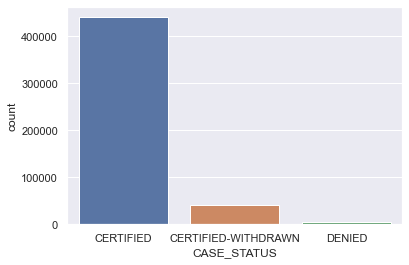

In [65]:
# H1-B Visa by Status
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="CASE_STATUS", data=df1)

print("{}% Petitions were Certified".format(len(df1[df1['CERTIFIED']=='Y'])/float(df1.shape[0])*100))
print("{}% Petitions were Denied".format(len(df1[df1['CERTIFIED']=='N'])/float(df1.shape[0])*100))

This is our response variable. It was selected to understand the proportion of the data falling into each class (Certified or Denied).  98.7% of the petitions were certified, which means that we may have an issue when predicting case outcome during modeling for the under-represented class.  

Based on this, we need to investigate balancing the data as we move from EDA to classification.

The visualization is appropriate as we are comparing the number of occurrences or frequency for each case status and box plots are good in these situations.

<Figure size 576x288 with 0 Axes>

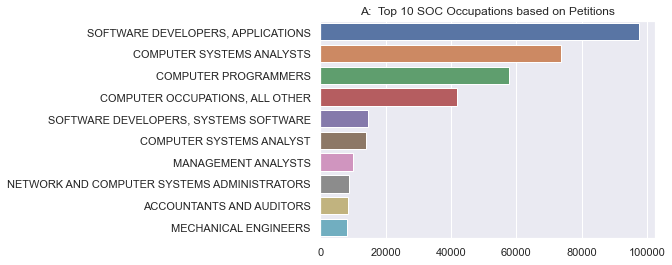

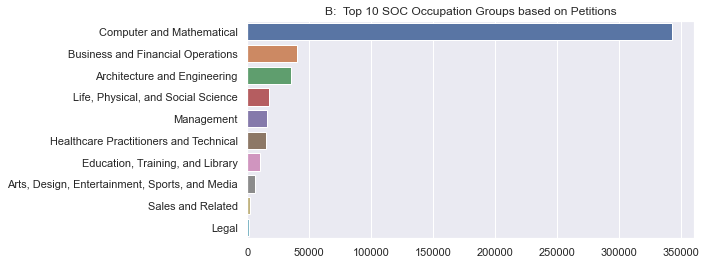

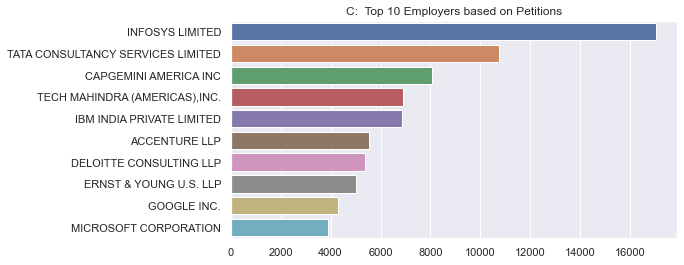

<Figure size 576x288 with 0 Axes>

In [66]:
#Top 10 SOC Occupations based on Petitions
soc = df1['SOC_NAME'].value_counts()[:10]
sns.barplot(x= soc.values, y = soc.index)
plt.title("A:  Top 10 SOC Occupations based on Petitions",y=1)
plt.figure(figsize=(8,4))

#Top 10 SOC Occupation Groups based on Petitions
soc = df1['SOC_GROUP'].value_counts()[:10]
sns.barplot(x= soc.values, y = soc.index)
plt.title("B:  Top 10 SOC Occupation Groups based on Petitions",y=1)
plt.figure(figsize=(8,4))

#Top 10 companies based on TOTAL_WORKERS
emp = df1['EMPLOYER_NAME'].value_counts()[:10]
sns.barplot(x= emp.values, y = emp.index)
plt.title("C:  Top 10 Employers based on Petitions",y=1)
plt.figure(figsize=(8,4))

The Standard Occupational Classification System (SOC Code) is the US government system of classifying occupations. There are approximately 900 SOC Codes. 

Chart A shows the top 10 SOC occupations, based on petitions submitted, 7 of which are computer related. While it is interesting to see which SOC occupations rank at the top, it may be more meaningful to view the data by SOC group, which collapses the 900 SOC Codes into 23 Occupation Groups.

This grouping is reflected in Chart B.  In addition to Computer and Mathmatical fields, the next largest occupational groups fall under Business and Financial Operations and Architecture and Engineering.

These findings are reasonable as the H-1B program is for hiring nonimmigrant aliens as workers in occupations that requires the application of a body of highly specialized knowledge. 

The key findings that the Computer and Mathmatical Group and occupations such as developers, systems analysts and programmers are the top petitioners for certification are further reinforced in Chart C.  Chart C indicates that the top 10 companies seeking H-1B visas are systems related industries.

These attributes were selected in order to understand and gain insight into what types of jobs are included and which emmployers are more likely to pursue H-1Bs.

The visualization is appropriate as it provides a clear comparison between the top ten rankings in each chart.

<Figure size 576x288 with 0 Axes>

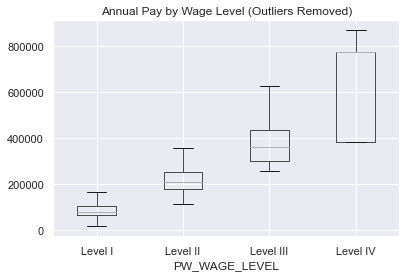

<Figure size 576x288 with 0 Axes>

In [67]:
df1.boxplot(column='ANNUALIZED_WAGE_RATE_OF_PAY', by='PW_WAGE_LEVEL', showfliers=False)
plt.title("Annual Pay by Wage Level (Outliers Removed)",y=1)
plt.suptitle("")
plt.figure(figsize=(8,4))


The above chart of Annual Pay by Wage Level (excluding outliers) indicates that Level III and IV have a wide distribution of annual pay and are skewed, while Level I is much more narrow.  The inter-quartile ranges are distinct, indicating stepped progression from one wage level to the next. 

A box plot was selected as this type of graph shows the dispersion of the dataset.

<AxesSubplot:ylabel='DAYS_PROCESS'>

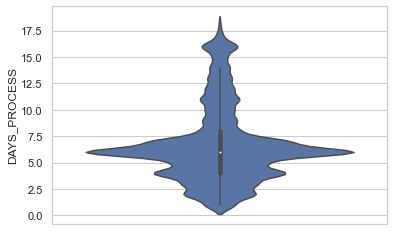

In [107]:
sns.violinplot(y=df_balanced['DAYS_PROCESS'], orient='vertical')

Days Processsed Variable
<br>
These values shows the majority number of days it takes the process of certification to be complete we see that most applications are certified about on the 6th day.

In [25]:
df1['countvar'] = 1

In [26]:
dftop = df1.groupby('EMPLOYER_NAME',as_index=False).count()

In [27]:
dftop = dftop.sort_values('countvar',ascending= False)[['EMPLOYER_NAME','countvar']]

In [28]:
dfempst = df1.groupby('EMPLOYER_STATE',as_index=False).count()[['EMPLOYER_STATE','countvar']].sort_values('countvar',ascending=False)

In [ ]:
from IPython.display import Image

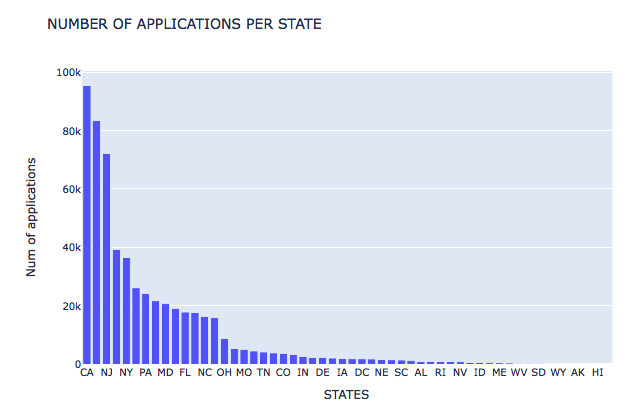

In [109]:
t1 = go.Bar(x=dfempst.EMPLOYER_STATE.values,y=dfempst.countvar.values,name='Employerstate')
layout = go.Layout(dict(title= "NUMBER OF APPLICATIONS PER STATE",xaxis=dict(title="STATES"),yaxis=dict(title="Num of applications")))
data = [t1]
fig =go.Figure(data,layout)
#fig.show()
Image(filename = 'no_applicants_.png')

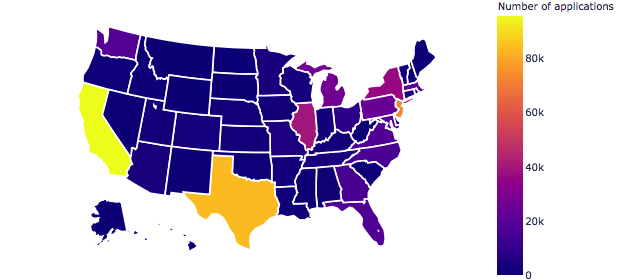

In [111]:
data=[dict(
    type='choropleth',
    locations = dfempst.EMPLOYER_STATE,
    z = dfempst.countvar,
    locationmode = 'USA-states',marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Number of applications")
)]
layout= dict(title="2011-2018 H1B VISA APPLICATIONS ( EMPLOYER STATE)",geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
fig = dict( data=data, layout=layout )
#iplot(fig)

Image(filename = 'Heatmap.png')

Based on the bar plot and heat map above, we can clearly see that California and Texas lead the pack based on number of petitions submitted.  New Jersey ranks a close third.  Considering California is home to "Silicon Valley", this is not surpising as we already saw that the computer occupation group ranks at the top.

These visualizations were chosen, especially the US Map, as it gives an immediate answer to the question of which states submit the most H-1B petitions for certification?

##### Outlier Identification and Treatment

After reviewing the simple statistic charts as well as some of the visualizations, outliers were identified. Visually, we can see these in the charts below. 

Chart A: The mean values of DAYS_PROCESS are significantly below the maximum value.  The mean was 33 days while the max number of days was 2214.

Chart B:  For ANNUALIZED_PREVAILING_WAGE the mean was 77,212 per year while, the maximum value was 868,440.

Chart C:  For ANNUALIZED_WAGE_RATE_OF_PAY the mean value was 93,184, while the max value was 2.5M per year. 

To ensure the integrity of the data that was kept, we divided these variable into three quartiles and subtracted the two quartiles to get the prevalent range of data, which we chose to make 92%.  We then took values that were 3 times the interquartile range (IQR) of 92%.  This method encompassed most of the data and left only very extreme outliers.

We chose to remove the outliers.  Jobs that had annualized pay amounts at the top of the outlier region tended to be C-Suite or highly specilized medical positions and not representative of the majority of the observations.  In addition, we know that unit of pay had errors, which we manually cleaned before calculating the annualized pay rates, but some may not have been caught.  

<Figure size 576x288 with 0 Axes>

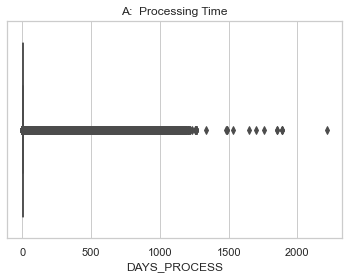

<Figure size 576x288 with 0 Axes>

In [46]:
sns.set_theme(style="whitegrid")

ax = sns.boxplot(x=df1["DAYS_PROCESS"])
plt.title("A:  Processing Time",y=1)
plt.figure(figsize=(8,4))

<Figure size 576x288 with 0 Axes>

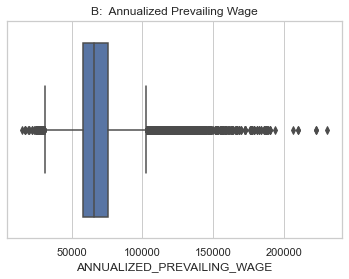

<Figure size 576x288 with 0 Axes>

In [47]:
ax = sns.boxplot(x=df1["ANNUALIZED_PREVAILING_WAGE"])
plt.title("B:  Annualized Prevailing Wage",y=1)
plt.figure(figsize=(8,4))

<Figure size 576x288 with 0 Axes>

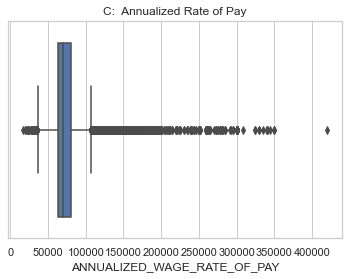

<Figure size 576x288 with 0 Axes>

In [48]:
ax = sns.boxplot(x=df1["ANNUALIZED_WAGE_RATE_OF_PAY"])
plt.title("C:  Annualized Rate of Pay",y=1)
plt.figure(figsize=(8,4))


In [49]:
# outilier removal code
Q1=df1['DAYS_PROCESS'].quantile(0.08)
Q3=df1['DAYS_PROCESS'].quantile(0.92)
IQR=Q3-Q1
#print(Q1)
#print(Q3)
#print(IQR)
Lower_Whisker = Q1-1.5*IQR
Upper_Whisker = Q3+1.5*IQR
print(Lower_Whisker, Upper_Whisker)

df_0 = df1[df1['DAYS_PROCESS']< Upper_Whisker]

Q1=df_0['ANNUALIZED_PREVAILING_WAGE'].quantile(0.8)
Q3=df_0['ANNUALIZED_PREVAILING_WAGE'].quantile(0.92)
IQR=Q3-Q1
#print(Q1)
#print(Q3)
#print(IQR)
Lower_Whisker = Q1-1.5*IQR
Upper_Whisker = Q3+1.5*IQR
print(Lower_Whisker, Upper_Whisker)

df_0 = df_0[df_0['ANNUALIZED_PREVAILING_WAGE']< Upper_Whisker]


Q1=df_0['ANNUALIZED_WAGE_RATE_OF_PAY'].quantile(0.8)
Q3=df_0['ANNUALIZED_WAGE_RATE_OF_PAY'].quantile(0.92)
IQR=Q3-Q1
#print(Q1)
#print(Q3)
#print(IQR)
Lower_Whisker = Q1-1.5*IQR
Upper_Whisker = Q3+1.5*IQR
print(Lower_Whisker, Upper_Whisker)

df = df_0[df_0['ANNUALIZED_WAGE_RATE_OF_PAY']< Upper_Whisker]

-29.0 59.0
59976.299999999996 110479.5
64896.0 118144.0


In [50]:
#Re run Summary Statistics for key columns
dfstat = pd.DataFrame([df.DAYS_PROCESS, df.ANNUALIZED_WAGE_RATE_OF_PAY, df.ANNUALIZED_PREVAILING_WAGE]).transpose()

dfstat.describe()

DAYS_PROCESS  ANNUALIZED_WAGE_RATE_OF_PAY  ANNUALIZED_PREVAILING_WAGE
count  84466.000000                 84466.000000                84466.000000
mean       6.170139                 72625.908523                67071.493148
std        4.024250                 13464.258341                13043.409975
min        1.000000                 16640.000000                15080.000000
25%        6.000000                 62754.000000                57533.000000
50%        6.000000                 70000.000000                65104.000000
75%        6.000000                 80000.000000                74443.000000
max       58.000000                118126.000000               110427.000000

Now that outliers have been addressed, we see improved core statistics for the three variables of interest.  Dispersion is reducded and standard deviation is more reasonable.  We also note marked  improvement in the max values across all three variables.

##### Visualizations With Balanced Data

In [51]:
df_balanced= pd.read_csv (r'Balanced_Visa_Data.csv')

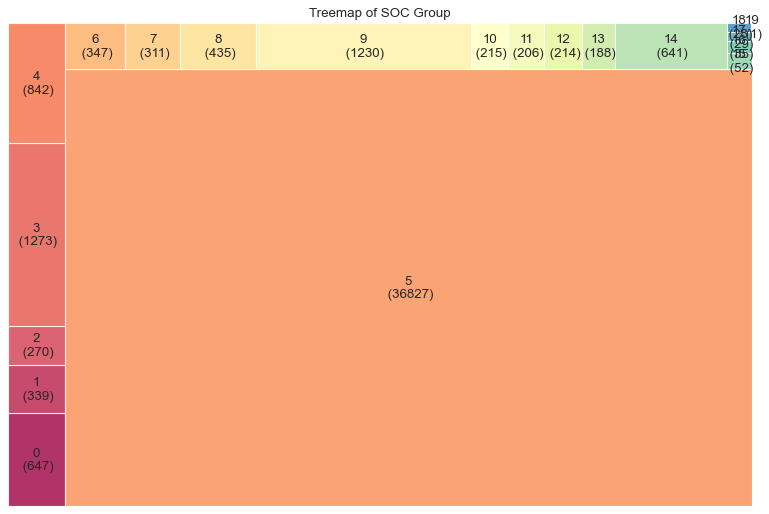

In [53]:
# Prepare Data
dfb = df_balanced.groupby('SOC_GROUP_CODE').size().reset_index(name='counts')
labels = dfb.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
sizes = dfb['counts'].values.tolist()
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

# Draw Plot
plt.figure(figsize=(12,8), dpi= 80)
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

# Decorate
plt.title('Treemap of SOC Group')
plt.axis('off')
plt.show()

SOC Group Variable

SOC Group indicates the fields of work that the H-1B applicant is being hired to fill. We can see that the majority of the employers are applying for Computer and Mathematics field. The codes of each field is given below as well as the number of application for those fields

SOC GROUP CODE KEY

{'Architecture and Engineering': 0,<br>
 'Arts, Design, Entertainment, Sports, and Media': 1,<br>
 'Building and Grounds Cleaning and Maintenance': 2,<br>
 'Business and Financial Operations': 3,<br>
 'Community and Social Service': 4,<br>
 'Computer and Mathematical': 5,<br>
 'Construction and Extraction': 6,<br>
 'Education, Training, and Library': 7,<br>
 'Food Preparation and Serving Related': 8,<br>
 'Healthcare Practitioners and Technical': 9,<br>
 'Healthcare Support': 10,<br>
 'Installation, Maintenance, and Repair': 11,<br>
 'Legal': 12,<br>
 'Life, Physical, and Social Science': 13,<br>
 'Management': 14,<br>
 'Office and Administrative Support': 15,<br>
 'Personal Care and Service': 16,<br>
 'Production': 17,<br>
 'Sales and Related': 18,<br>
 'Transportation and Material Moving': 19}<br>

In [119]:
VisaStatus_df = df_balanced.groupby(['SOC_GROUP']).size().reset_index(name='counts')
print(VisaStatus_df)

                                         SOC_GROUP  counts
0                     Architecture and Engineering     647
1   Arts, Design, Entertainment, Sports, and Media     339
2    Building and Grounds Cleaning and Maintenance     270
3                Business and Financial Operations    1273
4                     Community and Social Service     842
5                        Computer and Mathematical   36827
6                      Construction and Extraction     347
7                 Education, Training, and Library     311
8             Food Preparation and Serving Related     435
9           Healthcare Practitioners and Technical    1230
10                              Healthcare Support     215
11           Installation, Maintenance, and Repair     206
12                                           Legal     214
13              Life, Physical, and Social Science     188
14                                      Management     641
15               Office and Administrative Support      

### EXPLORE JOINT ATTRIBUTES
Visualize relationships between attributes: Look at the attributes via scatter plots, correlation, cross-tabulation, group-wise averages, etc. as appropriate. Explain any interesting relationships.


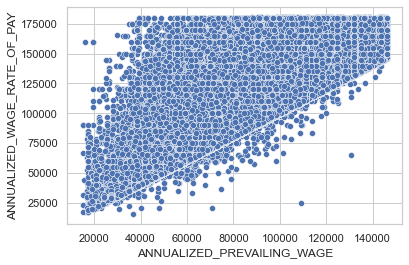

In [104]:
# Relationship between Prevailing Wage and Annualized Wage Rate

sns.scatterplot(data = df, x = "ANNUALIZED_PREVAILING_WAGE", y = "ANNUALIZED_WAGE_RATE_OF_PAY")
plt.show()

The above scatterplot of Annualized Wage Rate of Pay and Annualized Prevailing Wage indicates a positive correlation and confirms our belief that employers are providing pay levels higher than the prevailing wage for the position.

A scatterplot is a good choice for understanding relationships between two continuous variables.

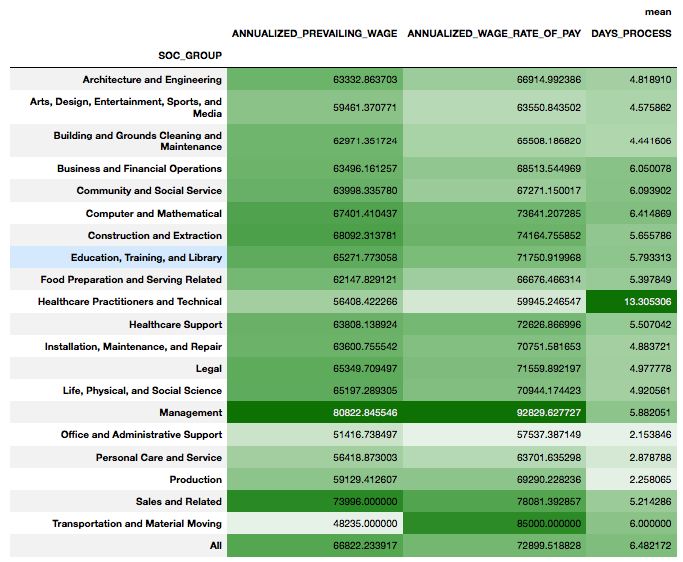

In [54]:
# UNBALANCED DATA
from IPython.display import Image
df_jobtype = pd.pivot_table(df_balanced,
                        values = ['DAYS_PROCESS','ANNUALIZED_PREVAILING_WAGE','ANNUALIZED_WAGE_RATE_OF_PAY'],
                        index = ['SOC_GROUP'],
                        columns = [],aggfunc=[np.mean], 
                        margins=True).fillna('')

cm = sns.light_palette("green", as_cmap=True)
df_jobtype.style.background_gradient(cmap=cm)
Image(filename = 'SOC_GROUP_WAGES.png')

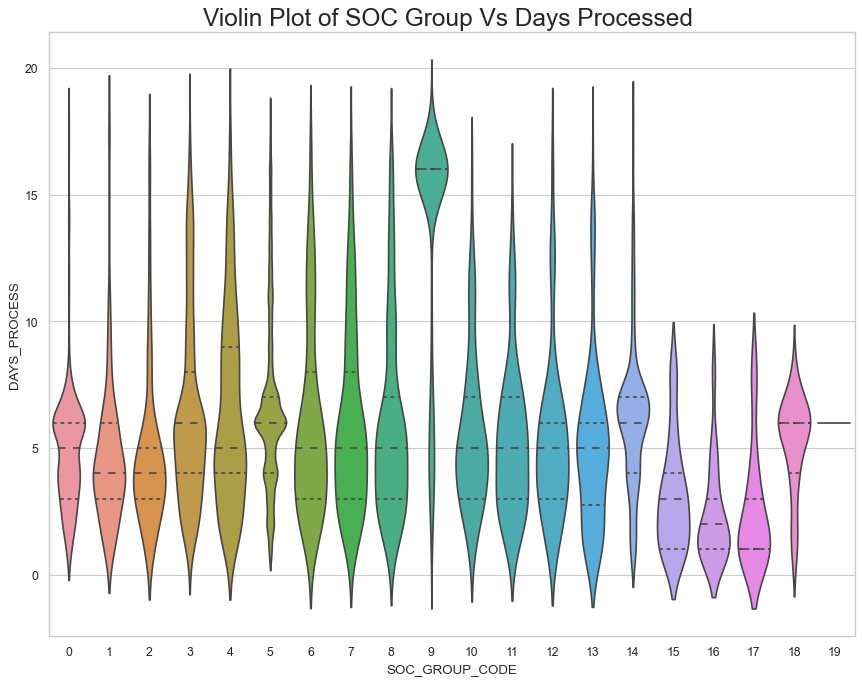

In [55]:
plt.figure(figsize=(13,10), dpi= 80)
sns.violinplot(x='SOC_GROUP_CODE', y='DAYS_PROCESS', data=df_balanced, scale='width', inner='quartile')

# Decoration
plt.title('Violin Plot of SOC Group Vs Days Processed ', fontsize=22)
plt.show()

Case status vs. Days Processed

From the plots above we see that the mean time for most fields of work is between 3 to 5 days, However there is one fiel, healthcare, that has a mean process time of about 16 days. Fields that are processed in the shortest amount of time are production workers and personal care services which both have a mean process time of about 3 days.

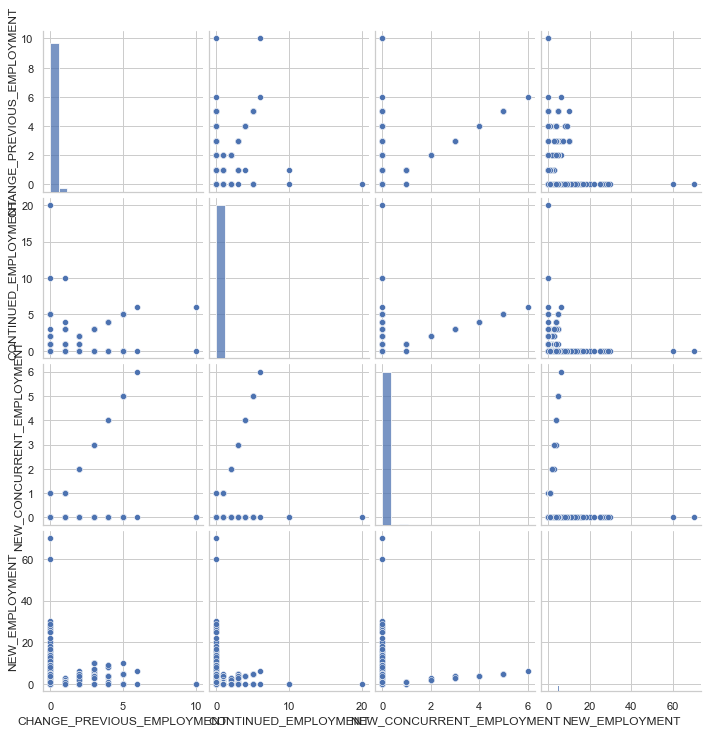

In [56]:
df_pairplot = df_balanced[['CHANGE_PREVIOUS_EMPLOYMENT', 'CONTINUED_EMPLOYMENT', 
                           'NEW_CONCURRENT_EMPLOYMENT', 'NEW_EMPLOYMENT']]

sns.pairplot(df_pairplot)

In [57]:
df_pairplot.corr()

CHANGE_PREVIOUS_EMPLOYMENT  CONTINUED_EMPLOYMENT  \
CHANGE_PREVIOUS_EMPLOYMENT                    1.000000              0.270023   
CONTINUED_EMPLOYMENT                          0.270023              1.000000   
NEW_CONCURRENT_EMPLOYMENT                     0.403213              0.287060   
NEW_EMPLOYMENT                                0.070875             -0.072920   

                            NEW_CONCURRENT_EMPLOYMENT  NEW_EMPLOYMENT  
CHANGE_PREVIOUS_EMPLOYMENT                   0.403213        0.070875  
CONTINUED_EMPLOYMENT                         0.287060       -0.072920  
NEW_CONCURRENT_EMPLOYMENT                    1.000000        0.057640  
NEW_EMPLOYMENT                               0.057640        1.000000

Correlation Plot
<br>
The above charts and tables show the correlation between the number of employees that had different employers from the country they are from, the employers that applied for induviduals that were working for the comapny in thier own country which is the continued employment, the change previous employment that is the employers that will apply for employees from their same comapany without cahnge to their previous job duties and the new concurrent which specifies that the employee will have employment from an additional employer  we see that the is not much correlation between these feilds as there is no correlation that is above 0.5 (50%). While the highest correltion is 0.42 which is new concurrent employment and change previous employment.

### EXPLORE ATTRIBUTES & CLASS
Identify and explain interesting relationships between features and the class you are trying to predict (i.e., relationships with variables and the target classification).


In [80]:
df_balanced.pivot_table(index='CASE_STATUS', columns='AGENT_REPRESENTING_EMPLOYER',
                    aggfunc={'H1B_DEPENDENT_CODE':sum,'ANNUALIZED_WAGE_RATE_OF_PAY':'mean', 'ANNUALIZED_PREVAILING_WAGE':'mean'})

ANNUALIZED_PREVAILING_WAGE                \
AGENT_REPRESENTING_EMPLOYER                          N             Y   
CASE_STATUS                                                            
CERTIFIED                                 67849.853698  66991.084370   
CERTIFIED-WITHDRAWN                       67298.066174  67505.360240   
DENIED                                    65846.633574  68455.860721   

                            ANNUALIZED_WAGE_RATE_OF_PAY                \
AGENT_REPRESENTING_EMPLOYER                           N             Y   
CASE_STATUS                                                             
CERTIFIED                                  72219.797885  76479.990020   
CERTIFIED-WITHDRAWN                        74258.336722  77570.841139   
DENIED                                     70414.373428  74985.572097   

                            H1B_DEPENDENT_CODE        
AGENT_REPRESENTING_EMPLOYER                  N     Y  
CASE_STATUS                                           
CERTIFIED                                 8547  5650  
CERTIFIED-WITHDRAWN                      11816  1707  
DENIED                                    9501  1229

Target (Case Status) vs. Annualized Prevailing Wage / Annualized Wage Rate of Pay  

A portion of the chart above is visualized in the bar plots below. The plots are integrated to show the relationship between the target variable (case status), agent representing the employer and the annualized prevailing wage. 

From the charts, it appears that in the case of annualized wage rate of pay (what the employer pays the H-1B applicant), employers that have an attorney or agent representing the company generally pay higher than the employers that do not. The difference in mean between the two groups is 4,374 for the certified applicants, 2,755 for the certified withdrawn applicants and 8,579 for the denied applicants. This means that the average difference for employers that had an attorney representing them was about 5,236.  For annualized prevailing wage there was little to no difference between the two groups.

We also noticed that a large number of employers that did not have an attorney representing them and were not H1B dependent later withdrew their certification (about 87%).  In addition, a large number of employers that did not have an attorney representing them and were not H1B dependent were about 88% of denied applications. However, for certified applicants there was minimal differences between the employers that had an attorney and those that did not, although the companies that had an attorney were slightly lower in number. 

The box plots below indicate that in all levels of case status: ceritifed, certified-withdrawn and denied; that the majority of companies are H1B dependent.

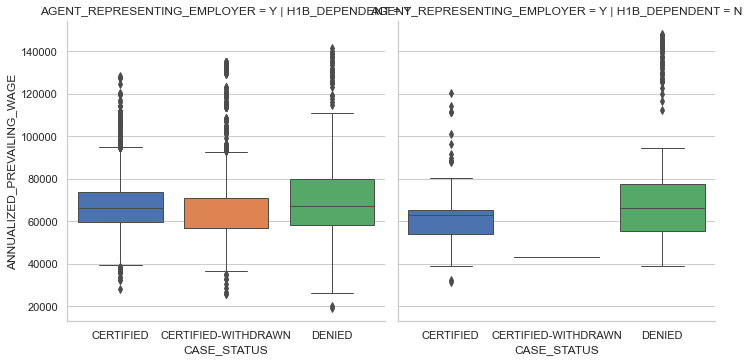

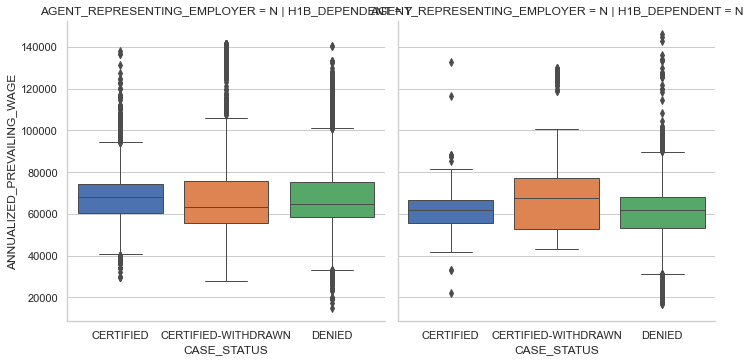

In [142]:
for i in set(df_balanced['AGENT_REPRESENTING_EMPLOYER']):
    aa= df_balanced[df_balanced['AGENT_REPRESENTING_EMPLOYER'].isin([i])]
    g = sns.factorplot(x='CASE_STATUS', y="ANNUALIZED_PREVAILING_WAGE",data=aa, 
                   saturation=1, kind="box", col = 'H1B_DEPENDENT', row = 'AGENT_REPRESENTING_EMPLOYER',
                   ci=None, aspect=1, linewidth=1) 

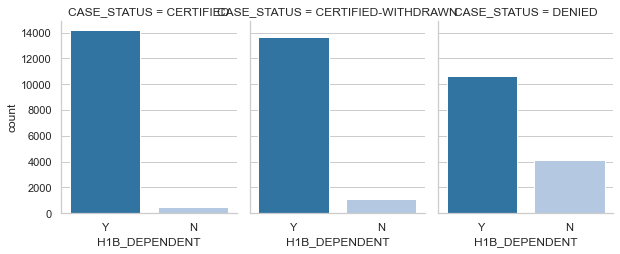

In [143]:
g = sns.catplot("H1B_DEPENDENT", col="CASE_STATUS", col_wrap=4,
                data=df_balanced[df_balanced.NEW_EMPLOYMENT.notnull()],
                kind="count", height=3.5, aspect=.8, 
                palette='tab20')
plt.show()

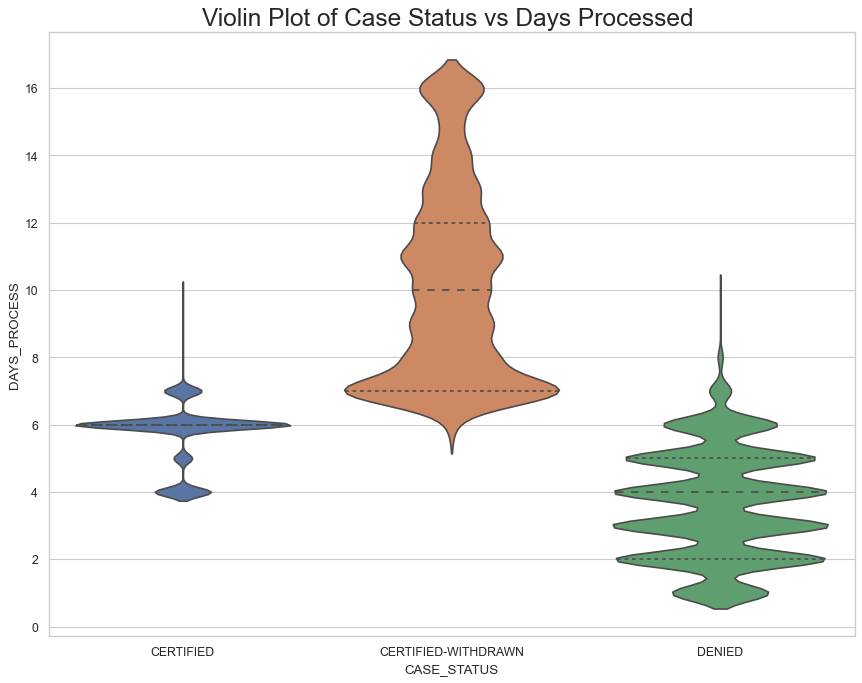

In [86]:
plt.figure(figsize=(13,10), dpi= 80)
sns.violinplot(x='CASE_STATUS', y='DAYS_PROCESS', data=df_balanced, scale='width', inner='quartile')

# Decoration
plt.title('Violin Plot of Case Status vs Days Processed ', fontsize=22)
plt.show()

Case Status vs. Days Processed

In terms of processing time, the plot above indicates that the certified-withdrawn status generally has a higher mean than all other categories and the denied status has the shortest. Certified cases tend to receive results in approximately 6 days.

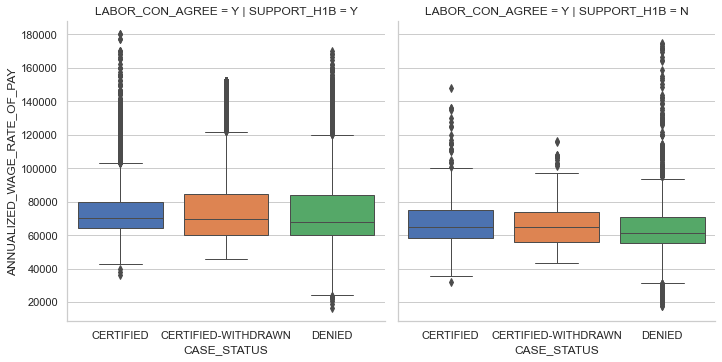

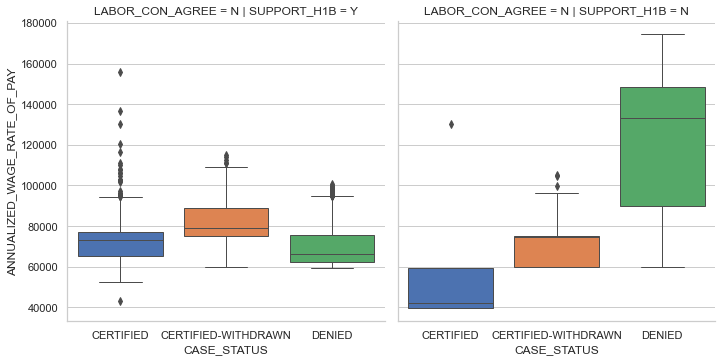

In [144]:
for i in set(df_balanced['LABOR_CON_AGREE']):
    aa= df_balanced[df_balanced['LABOR_CON_AGREE'].isin([i])]
    g = sns.factorplot(x='CASE_STATUS', y="ANNUALIZED_WAGE_RATE_OF_PAY",data=aa, 
                   saturation=1, kind="box", col = 'SUPPORT_H1B', row = 'LABOR_CON_AGREE',
                   ci=None, aspect=1, linewidth=1) 

Annnualized Wage Rate of Pay

When the labor condition agreemant is not available and the company does not need a labor condition agreement, the mean rate of denial is high; while the certified cases in this condition is the lowest.

All other coditions regarding the labor condition agreement and whether the employer supports H1B, that is they need the labor codition agreement to certify their applicant, is near similar.  However,  in the case where the employer needs the H1B agreement, hence support H1B, and there is no labor condition agreement, the denial rate seems to be slightly lower. 

The cross table is shown below

In [88]:
df_balanced.pivot_table(index='CASE_STATUS', columns='SUPPORT_H1B',
                    aggfunc={'LABOR_CON_AGREE_CODE':sum, 'ANNUALIZED_PREVAILING_WAGE':'mean'})

ANNUALIZED_PREVAILING_WAGE                \
SUPPORT_H1B                                  N             Y   
CASE_STATUS                                                    
CERTIFIED                         62258.625760  67766.042802   
CERTIFIED-WITHDRAWN               63231.809077  67758.188396   
DENIED                            59998.685693  67826.513376   

                    LABOR_CON_AGREE_CODE         
SUPPORT_H1B                            N      Y  
CASE_STATUS                                      
CERTIFIED                            686  13056  
CERTIFIED-WITHDRAWN                 1392  12924  
DENIED                              3161  10941

### NEW FEATURES
Are there other features that could be added to the data or created from existing features? Which ones?

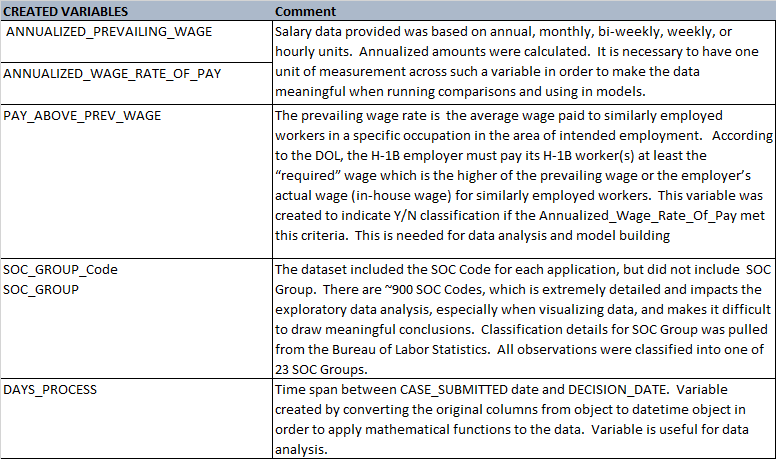

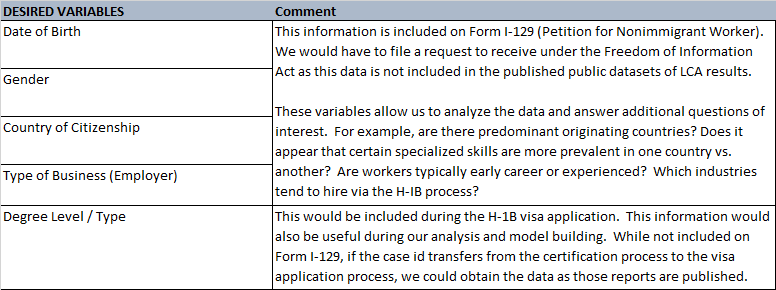

### EXCEPTIONAL WORK

You have free reign to provide additional analyses. One idea: implement dimensionality reduction, then visualize and interpret the results.

Balancing / Encoding Data


From the plots below we can see that there is an extremely low amount of Denied and Certified withdrawn. These values will not be able to give us clear understanding of what is happeneing in the data so the lower classes need to be upscaled to meet the number of values for the Certified class.

A python module label encoder was importeed to encode the string variable features and change them to floats, because the balancing module that will be used cannot work with string characters. The module used to balance the data is SMOTE. In this project we chose to upscale the variable since the smaller variable were too small.

However before we balanced the data in order to reduce the unevenness of the of the upscale the certified column was reduced in number from 84,710 to 14,537

In [95]:
df= pd.read_csv (r'cleaned_Visa_Data.csv')
df= df.drop(['Unnamed: 0'], axis=1)
VisaStatus_df = df.groupby(['CASE_STATUS']).size().reset_index(name='counts')
print(VisaStatus_df)

           CASE_STATUS  counts
0            CERTIFIED   84710
1  CERTIFIED-WITHDRAWN     828
2               DENIED     864


<AxesSubplot:title={'center':'count (target)'}>

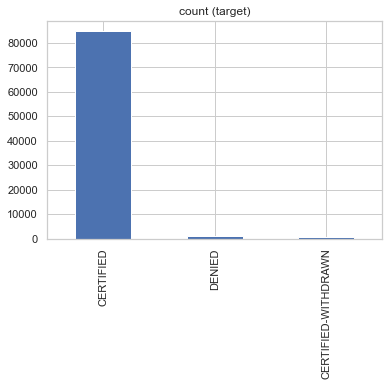

In [96]:
df['CASE_STATUS'].value_counts().plot(kind='bar', title='count (target)')

In [97]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

In [98]:
features = ['EMPLOYER_NAME', 'EMPLOYER_CITY','SOC_NAME','SOC_GROUP',
           'EMPLOYER_STATE', 'AGENT_REPRESENTING_EMPLOYER', 'JOB_TITLE',
            'WILLFUL_VIOLATOR','WORKSITE_CITY','WORKSITE_STATE','PW_UNIT_OF_PAY',
           'PW_WAGE_LEVEL','WAGE_UNIT_OF_PAY','H1B_DEPENDENT','SUPPORT_H1B','LABOR_CON_AGREE']
encoded = []

keys = {}

le = LabelEncoder()

for f in features:
    df[f+'_CODE'] = le.fit_transform(df[f])
    b=f+'_CODE'
    encoded.append(b)
    keys[f+'_CODE'] = {l: i for i, l in enumerate(le.classes_)}
    
df_cut = df.drop(['DECISION_DATE','CASE_SUBMITTED','CASE_NUMBER'], axis=1)

df_cut.head(3)

CASE_STATUS  EMPLOYER_NAME   EMPLOYER_CITY EMPLOYER_STATE  \
0   CERTIFIED  WIPRO LIMITED  EAST BRUNSWICK             NJ   
1   CERTIFIED  WIPRO LIMITED  EAST BRUNSWICK             NJ   
2   CERTIFIED  WIPRO LIMITED  EAST BRUNSWICK             NJ   

  AGENT_REPRESENTING_EMPLOYER           JOB_TITLE SOC_CODE  \
0                           N     PROJECT MANAGER  15-1199   
1                           N   VLSI ARCHITECT-L1  17-2072   
2                           N  PROGRAMMER ANALYST  15-1131   

                                 SOC_NAME  SOC_GROUP_Code  \
0         COMPUTER OCCUPATIONS, ALL OTHER              15   
1  ELECTRONICS ENGINEERS, EXCEPT COMPUTER              17   
2                    COMPUTER PROGRAMMERS              15   

                      SOC_GROUP  ...  JOB_TITLE_CODE  WILLFUL_VIOLATOR_CODE  \
0     Computer and Mathematical  ...            3607                      0   
1  Architecture and Engineering  ...            6437                      0   
2     Computer and Mathematical  ...            3365                      0   

   WORKSITE_CITY_CODE  WORKSITE_STATE_CODE  PW_UNIT_OF_PAY_CODE  \
0                  76                    0                    4   
1                  76                    0                    4   
2                  76                    0                    4   

   PW_WAGE_LEVEL_CODE  WAGE_UNIT_OF_PAY_CODE H1B_DEPENDENT_CODE  \
0                   0                      4                  1   
1                   0                      4                  1   
2                   0                      4                  1   

  SUPPORT_H1B_CODE  LABOR_CON_AGREE_CODE  
0                1                     0  
1                1                     0  
2                1                     0  

[3 rows x 45 columns]

In [99]:
# Reduse the number of Certified from 84,710 to 14,537 to reduce extreme upscale
df_cut=df_cut.sort_values(by=['CASE_STATUS'])
df_cut=df_cut.iloc[70000:, :]

VisaStatus_df = df_cut.groupby(['CASE_STATUS']).size().reset_index(name='counts')
print(VisaStatus_df)

           CASE_STATUS  counts
0            CERTIFIED   14710
1  CERTIFIED-WITHDRAWN     828
2               DENIED     864


In [100]:
# Oversmaple the rest of the data to the upsacle to the y variable (CASE_STATUS)
yy = df_cut['CASE_STATUS']
X = df_cut.drop(['CASE_STATUS','EMPLOYER_NAME', 'EMPLOYER_CITY','SOC_GROUP',
             'SOC_NAME','EMPLOYER_STATE', 'AGENT_REPRESENTING_EMPLOYER', 'JOB_TITLE',
            'WILLFUL_VIOLATOR','WORKSITE_CITY','WORKSITE_STATE',
            'PW_UNIT_OF_PAY','PW_WAGE_LEVEL','WAGE_UNIT_OF_PAY','H1B_DEPENDENT',
            'WILLFUL_VIOLATOR','WORKSITE_CITY','WORKSITE_STATE','SOC_CODE'
                ,'SUPPORT_H1B','LABOR_CON_AGREE'], axis=1)

In [101]:
y = LabelEncoder().fit_transform(yy)

In [102]:
from collections import Counter


oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=0, n=14710 (33.333%)
Class=1, n=14710 (33.333%)
Class=2, n=14710 (33.333%)


In [103]:
coded_df = X
coded_df['CASE_STATUS_CODE'] = y

VisaStatus_df = coded_df.groupby(['CASE_STATUS_CODE']).size().reset_index(name='counts')
print(VisaStatus_df)

   CASE_STATUS_CODE  counts
0                 0   14710
1                 1   14710
2                 2   14710


In [104]:
# column header to be puuled from encoded dataset
recode = list(zip(encoded,features))
recoded = []
for i in recode:
    recoded.append(list(i))
recoded

[['EMPLOYER_NAME_CODE', 'EMPLOYER_NAME'],
 ['EMPLOYER_CITY_CODE', 'EMPLOYER_CITY'],
 ['SOC_NAME_CODE', 'SOC_NAME'],
 ['SOC_GROUP_CODE', 'SOC_GROUP'],
 ['EMPLOYER_STATE_CODE', 'EMPLOYER_STATE'],
 ['AGENT_REPRESENTING_EMPLOYER_CODE', 'AGENT_REPRESENTING_EMPLOYER'],
 ['JOB_TITLE_CODE', 'JOB_TITLE'],
 ['WILLFUL_VIOLATOR_CODE', 'WILLFUL_VIOLATOR'],
 ['WORKSITE_CITY_CODE', 'WORKSITE_CITY'],
 ['WORKSITE_STATE_CODE', 'WORKSITE_STATE'],
 ['PW_UNIT_OF_PAY_CODE', 'PW_UNIT_OF_PAY'],
 ['PW_WAGE_LEVEL_CODE', 'PW_WAGE_LEVEL'],
 ['WAGE_UNIT_OF_PAY_CODE', 'WAGE_UNIT_OF_PAY'],
 ['H1B_DEPENDENT_CODE', 'H1B_DEPENDENT'],
 ['SUPPORT_H1B_CODE', 'SUPPORT_H1B'],
 ['LABOR_CON_AGREE_CODE', 'LABOR_CON_AGREE']]

In [105]:
#pulling values from encoded df
codes = []
for i in recoded:
    temp = df[i]
    codes.append(temp.drop_duplicates())

Exceptional work - Recoding data

After the data is balanced and upscaled all the variables are left in the is numeric form. theis would not be appropriate for visualization as there will not be descriptive labeles on the charts. So using For loops and zip function we pull the features and the codes from the unbalanced but encoded data set to and using left merge join then induvidually to the balanced data set so that the string values can be used for EDA.

<AxesSubplot:title={'center':'count (target)'}>

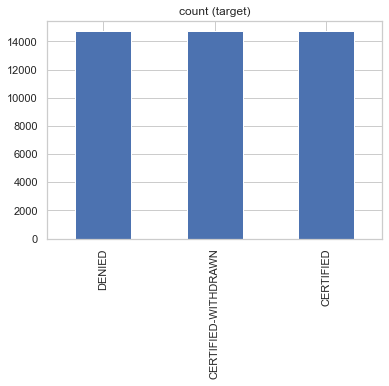

In [106]:
#merge data set to recode the required columns
import numpy as np

coded_data = coded_df.merge(codes[0], on='EMPLOYER_NAME_CODE', how = 'left')
coded_data = coded_data.merge(codes[1], on='EMPLOYER_CITY_CODE', how = 'left')
coded_data = coded_data.merge(codes[2], on='SOC_NAME_CODE', how = 'left')
coded_data = coded_data.merge(codes[3], on='SOC_GROUP_CODE', how = 'left')
coded_data = coded_data.merge(codes[4], on='EMPLOYER_STATE_CODE', how = 'left')
coded_data = coded_data.merge(codes[5], on='AGENT_REPRESENTING_EMPLOYER_CODE', how = 'left')
coded_data = coded_data.merge(codes[6], on='JOB_TITLE_CODE', how = 'left')
coded_data = coded_data.merge(codes[7], on='WILLFUL_VIOLATOR_CODE', how = 'left')
coded_data = coded_data.merge(codes[8], on='WORKSITE_CITY_CODE', how = 'left')
coded_data = coded_data.merge(codes[9], on='WORKSITE_STATE_CODE', how = 'left')
coded_data = coded_data.merge(codes[10], on='PW_UNIT_OF_PAY_CODE', how = 'left')
coded_data = coded_data.merge(codes[11], on='PW_WAGE_LEVEL_CODE', how = 'left')
coded_data = coded_data.merge(codes[12], on='WAGE_UNIT_OF_PAY_CODE', how = 'left')
coded_data = coded_data.merge(codes[13], on='H1B_DEPENDENT_CODE', how = 'left')
coded_data = coded_data.merge(codes[14], on='SUPPORT_H1B_CODE', how = 'left')
coded_data = coded_data.merge(codes[15], on='LABOR_CON_AGREE_CODE', how = 'left')


coded_data['CASE_STATUS'] = np.select([coded_data.CASE_STATUS_CODE == 0, coded_data.CASE_STATUS_CODE == 1], 
                        ['CERTIFIED', 'CERTIFIED-WITHDRAWN'], 
                        default='DENIED')

coded_data['CASE_STATUS'].value_counts().plot(kind='bar', title='count (target)')